# Twitter Dataset

In [20]:
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
import operator 
import json
from collections import defaultdict

import pickle
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pyLDAvis
from nltk.corpus import stopwords

import seaborn as sns

import gensim
from gensim.corpora import Dictionary, TextCorpus, MmCorpus

In [21]:
np.random.seed(22)
sns.set(color_codes=True)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 200)

## Twitter tokenization

In [22]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

## Read dataset

In [23]:
class DataSet():
    def __init__(self):
        self.invalidate()
        pass
    
    def save(self, df):
        df.to_pickle('./data/' + df.name + '.pkl')
        return df
    
    def invalidate(self):
        self.dfnormalized = None
        return self

    def load(self):
        try:
          self.df = pd.read_pickle('./data/tweets.pkl')
        except FileNotFoundError:
          self.df = self.read_dataset()
          self.df.to_pickle('./data/tweets.pkl')
            
        #self.df = self.df.ix[0:10000]
        return self
        
    def read_dataset(self):
        return pd.read_csv('./data/election_day_tweets.csv')

    def normalized(self):
        if self.dfnormalized is not None:
            return self.dfnormalized

        df = self.df['text created_at lang user.location user.time_zone retweeted retweet_count id'.split(' ')]
        df = df.assign(created_at=df['created_at'].apply(pd.Timestamp))
        df = df.set_index('created_at')
        df = df.sort_index()
        df = df[df['lang'] == 'en']
        # Add text length data
        df = df.assign(length=df['text'].apply(lambda x: len(x)))
        df.name = 'normalized'
        
        self.dfnormalized = df
        
        return df

    def group(self, interval='15min'):
        df = self.normalized()['text length'.split(' ')]
        grouped = df.groupby(pd.TimeGrouper(interval))
        df = grouped.agg({
            'text': lambda x: ''.join(set(x)),
            'length': np.sum
        })
        df = df.assign(count=grouped['text'].count())
        
        return df
    
    def plot_count(self, interval):
        return self.group(interval)['count'].plot(kind='bar')
    
    def tokens(self, interval=None):
        df = self.normalized() if interval is None else self.group(interval)
        # Add token data
        df = df.assign(tokens=df['text'].apply(lambda x: preprocess(x, True)))
        # Add cleaned token data
        others = ['•','💙','🇸','🇺','…']
        useless = set(stopwords.words('english')).union(set(string.punctuation)).union(set(others))
        df = df.assign(cleaned_tokens=df['tokens'].apply(\
          lambda tokens: list(filter(\
            lambda x: x is not None, [None if t in useless else t for t in tokens] \
          ))\
        ))
        
        election_tags = ['#electionnight', '#election2016i', '#election2016', '#electionday', '#uselection2016', '#elections2016']
        df = df.assign(hashtags=df['cleaned_tokens'].apply(\
          lambda tokens: list(filter(\
            lambda x: x is not None, [t if (t.startswith('#') and t not in election_tags) else None for t in tokens] \
          ))\
        ))
        
        df = df.assign(hashtags_election=df['cleaned_tokens'].apply(\
          lambda tokens: list(filter(\
            lambda x: x is not None, [t if t in election_tags else None for t in tokens] \
          ))\
        ))
        
        df = df.assign(addressed_to=df['cleaned_tokens'].apply(\
          lambda tokens: list(filter(\
            lambda x: x is not None, [t if t.startswith('@') else None for t in tokens] \
          ))\
        ))
        
        df = df.assign(cleaned_tokens=df['cleaned_tokens'].apply(\
          lambda tokens: list(filter(\
            lambda x: x is not None, [None if (t.startswith('#') or t.startswith('@')) else t for t in tokens] \
          ))\
        ))
        
        return df
    
    def plot_agg(self, agg, interval=None):
        self.tokens(interval)[agg]

    def analyze_tokens(self, interval=None):
        if interval is None:
            interval = '1d'
        
        df = self.tokens(interval)
        counter = Counter()

        def _count(x):
            counter = Counter()
            counter.update(x)
            return counter

        token_counter = df['cleaned_tokens'].apply(_count)
        df = df.assign(token_counter=token_counter)

        hashtag_counter = df['hashtags'].apply(_count)
        df = df.assign(hashtag_counter=hashtag_counter)

        hashtag_election_counter = df['hashtags_election'].apply(_count)
        df = df.assign(hashtag_election_counter=hashtag_election_counter)

        addressed_to_counter = df['addressed_to'].apply(_count)
        df = df.assign(addressed_to_counter=addressed_to_counter)

        return df
    
    def plot_hashtag(self, day, number=10):
        d = defaultdict(int)
        sns.set_context("notebook", font_scale=1.5)

        for v, k in ds.analyze_tokens('1d')['hashtag_counter'].apply(lambda x: x.most_common(number)).ix[day - 1]:
          d[v] = k
        df = pd.DataFrame(data={
         'hashtag': list(d.keys()),
         'count': list(d.values())
        }).sort_values('count', ascending=False)

        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 5))
        sns.set_context("poster",font_scale=.7)

        # Plot the total crashes
        sns.set_color_codes("pastel")
        sns.barplot(x="count", y="hashtag", data=df,
                    label="Total", color="b")

        # Add a legend and informative axis label
        ax.legend(ncol=2, loc="lower right", frameon=True)
        ax.set(ylabel="",
               xlabel="Most popular hash tag on election day " + str(day))
        sns.despine(left=True, bottom=True)

    def plot_tokens(self, day, number=10):
        d = defaultdict(int)
        sns.set_context("notebook", font_scale=1.5)

        for v, k in ds.analyze_tokens('1d')['token_counter'].apply(lambda x: x.most_common(number)).ix[day - 1]:
          d[v] = k
        df = pd.DataFrame(data={
         'tokens': list(d.keys()),
         'count': list(d.values())
        }).sort_values('count', ascending=False)

        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 5))
        sns.set_context("poster",font_scale=.7)

        # Plot the total crashes
        sns.set_color_codes("pastel")
        sns.barplot(x="count", y="tokens", data=df,
                    label="Total", color="b")

        # Add a legend and informative axis label
        ax.legend(ncol=2, loc="lower right", frameon=True)
        ax.set(ylabel="",
               xlabel="Most popular words on election day " + str(day))
        sns.despine(left=True, bottom=True)

    
        

In [27]:
timeit ds = DataSet().load()

1 loop, best of 3: 1.06 s per loop


In [ ]:
ds.plot_hashtag(1)
ds.plot_hashtag(2)

/Users/rngadam/Downloads/tweets/venv/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/Users/rngadam/Downloads/tweets/venv/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


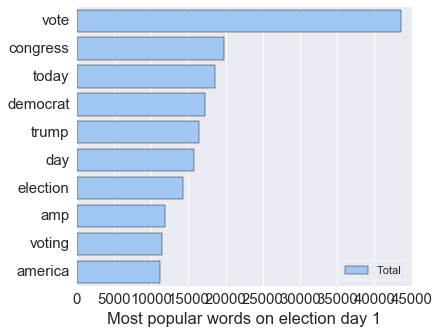

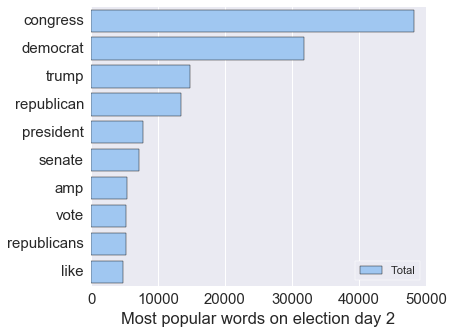

In [26]:
ds.plot_tokens(1, 10)
ds.plot_tokens(2, 10)